In [2]:
%%capture 

# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

In [3]:
import pennylane as qml
from pennylane import numpy as np


# Computing quantum gradients on any device

In the last two notebooks we saw that PennyLane allows you to seamlessly "slot" quantum computations into automatic differentiation frameworks. While we used the Numpy/Autograd framework, you can also interface PennyLane with PyTorch, Tensorflow and Jax.

If quantum computations are *simulated* by coding up matrix-vector multiplications in a specific coding language,  they just become differentiable computations. This is the trick that the `default.qubit` device uses if possible: it knows how to simulate quantum circuits in Autograd, TensorFlow etc. But what if we use a device that is not implemented in an automatic differentiation fashion? And what if the device uses quantum hardware?

In PennyLane, any quantum device, whether a hardware device or a simulator, can be trained using the [parameter-shift rule](https://pennylane.ai/qml/glossary/parameter_shift.html) to compute quantum gradients. Indeed, the parameter-shift rule is ideally suited to hardware devices, as it does
not require any knowledge about the internal workings of the device; it is sufficient to treat the device as a 'black box', and to query it with different input values in order to determine the gradient.

## 1. The parameter-shift rule


The parameter-shift rule states that, given a variational quantum circuit $U(\boldsymbol
\theta)$ composed of parametrized Pauli rotations, and some measured observable $\mathcal{M}$, the
derivative of the expectation value


\begin{align}\langle \mathcal{M} \rangle (\boldsymbol\theta) =
    \langle 0 \vert U(\boldsymbol\theta)^\dagger \mathcal{M} U(\boldsymbol\theta) \vert 0\rangle\end{align}

with respect to the input circuit parameters $\boldsymbol{\theta}$ is given by

\begin{align}\nabla_{\theta_i}\langle \mathcal{M} \rangle(\boldsymbol\theta)
      =  \frac{1}{2}
            \left[
                \langle \mathcal{M} \rangle\left(\boldsymbol\theta + \frac{\pi}{2}\hat{\mathbf{e}}_i\right)
              - \langle \mathcal{M} \rangle\left(\boldsymbol\theta - \frac{\pi}{2}\hat{\mathbf{e}}_i\right)
            \right].\end{align}

Thus, the gradient of the expectation value can be calculated by evaluating the same variational quantum circuit, but with shifted parameter values (hence the name, parameter-shift rule!).



## 2. Hand-coded parameter-shift rule

Let's first have a go implementing the parameter-shift rule manually. We use the quantum model from the previous notebook.

In [4]:
dev = qml.device("default.qubit", wires=2) 

In [5]:
@qml.qnode(dev, diff_method='parameter-shift')
def quantum_model(x, w):
    qml.templates.AngleEmbedding(x, wires=[0, 1])
    qml.templates.BasicEntanglerLayers(w, wires=[0, 1])
    return qml.expval(qml.PauliZ(wires=1))

x = np.array([0.1, 0.2], requires_grad=False)
w = np.array([[-2.1, 1.2], [-1.4, -3.9], [0.5, 0.2]])

quantum_model(x, w)

tensor(-0.0471305, requires_grad=True)

In [6]:
print(quantum_model.draw())

 0: ──RX(0.1)──RX(-2.1)──╭C──RX(-1.4)──╭C──RX(0.5)──╭C──┤     
 1: ──RX(0.2)──RX(1.2)───╰X──RX(-3.9)──╰X──RX(0.2)──╰X──┤ ⟨Z⟩ 



Now that we have defined our variational circuit QNode, we can construct
a function that computes the gradient of the $i\text{th}$ parameter
using the parameter-shift rule. Since the model also depends on input $x$, the gradient will be computed for this fixed $x$ only.


In [7]:
def parameter_shift_term(qnode, params, x, i, j):
    
    shifted = params.copy()
    
    shifted[i, j] += np.pi/2
    forward = qnode(x, shifted)  # forward evaluation

    shifted[i, j] -= np.pi
    backward = qnode(x, shifted) # backward evaluation

    return 0.5 * (forward - backward)

# gradient with respect to the first parameter
print(parameter_shift_term(quantum_model, w, x, 0, 0))

-0.6646069909211211


In order to compute the gradient with respect to *all* parameters, we need
to loop over the indices ``i`` and ``j``:



In [8]:
def parameter_shift(qnode, params, x):
    gradients = np.zeros_like((params))

    for i in range(len(gradients)):
        for j in range(len(gradients[0])):
            gradients[i, j] = parameter_shift_term(qnode, w, x, i, j)

    return gradients

print(parameter_shift(quantum_model, w, x))

[[-0.66460699  0.0527491 ]
 [ 0.          0.0527491 ]
 [-0.66460699  0.0527491 ]]


## 3. Built-in parameter shift differentiation

We can compare this to PennyLane's *built-in* parameter-shift feature by using
the `qml.grad` function. Remember, when we defined the
QNode, we specified that we wanted it to be differentiable using the parameter-shift
method (``diff_method="parameter-shift"``).


In [9]:
grad_function = qml.grad(quantum_model, argnum=1)

print(grad_function(x, w))

[[-0.66460699  0.0527491 ]
 [ 0.          0.0527491 ]
 [-0.66460699  0.0527491 ]]


If you count the number of quantum evaluations, you will notice that we had to evaluate the circuit roughly
``2*len(params)`` number of times in order to compute the quantum gradient with respect to all
parameters. 




In [10]:
before = dev.num_executions 
grad_function = qml.grad(quantum_model, argnum=1)
grad_function(x, w)
after = dev.num_executions
print("Number of evaluations per gradient:", after-before)

Number of evaluations per gradient: 13


While reasonably fast for a small number of parameters, as the number of parameters in
our quantum circuit grows, so does both

1. the circuit depth (and thus the time taken to evaluate each expectation value or 'forward' pass), and

2. the number of parameter-shift evaluations required.

Both of these factors increase the time taken to compute the gradient with
respect to all parameters.

It is therefore crucial to develop efficient pipelines for the evaluation of gradients in quantum machine learning. If you want to learn more about this, check out the [Amazon-Braket demo](https://pennylane.ai/qml/demos/braket-parallel-gradients.html), which explains how PennyLane and AWS have teamed up to paralellise the evaluation of quantum gradients.

#  TASKS

1. Create a new `default.qubit` device where you can set the `diff_method` explicitely to `diff_method = 'backprop'`. This will use automatic differentiation tricks to compute gradients much more efficiently for simulations (as implicitely used in the previous notebooks). Find out how often the device is evaluated when you compute a gradient using the `qml.grad` function. 

In [11]:
dev = qml.device("default.qubit", wires=2) 

@qml.qnode(dev, diff_method='backprop')
def quantum_model(x, w):
    qml.templates.AngleEmbedding(x, wires=[0, 1])
    qml.templates.BasicEntanglerLayers(w, wires=[0, 1])
    return qml.expval(qml.PauliZ(wires=1))


grad_function = qml.grad(quantum_model, argnum=1)

before = dev.num_executions 
grad_function = qml.grad(quantum_model, argnum=1)
grad_function(x, w)
after = dev.num_executions
print("Number of evaluations per gradient:", after-before)

Number of evaluations per gradient: 1


2. In each step of gradient descent we need to compute the gradient of a quantum computation. Write a function `num_evals(n_params, n_steps)` that takes the number of parameters as well as the number of steps and returns the number of circuit evaluations needed for gradient descent training with a parameter shift rule. Let's say you need as many training steps as you have parameters or `n_steps=n_params`. Plot the number of circuit evaluations over the number of parameters. What scaling behaviour do you see? Compare this to a scaling in which each step only takes a single evaluation.

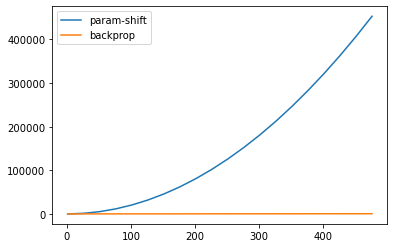

In [1]:
import matplotlib.pyplot as plt

# note: this function implicitly assumes
# single-batch training
def num_evals(n_params, n_steps):
    return 2*n_params*n_steps

x_axis = range(1, 500, 25)
scaling = [num_evals(i, i) for i in x_axis]

plt.plot(x_axis, scaling, label="param-shift")
plt.plot(x_axis, [x for x in x_axis], label="backprop")
plt.legend()
plt.show()